#  AD Tutorial - CLAD & Jupyter Notebook CIAO

xeus-cling provides a Jupyter kernel for C++ with the help of the C++ interpreter cling and the native implementation of the Jupyter protocol xeus.

Within the xeus-cling framework, Clad can enable automatic differentiation (AD) such that users can automatically generate C++ code for their computation of derivatives of their functions.



In [1]:
#include <string>
#include <fstream>

#include "xtl/xbase64.hpp"

#include "nlohmann/json.hpp"
#pragma cling add_include_path("/srv/conda/envs/notebook/include/python3.7m")
#pragma cling add_library_path("/srv/conda/envs/notebook/lib/")
#pragma cling load("python3.7m")


In [2]:
!python3-config --libs

-lpython3.7m -lcrypt -lpthread -ldl  -lutil -lrt -lm 


In [3]:
#include "clad/Differentiator/Differentiator.h"
#include <iostream>


#include "../../matplotlibcpp.h"

namespace plt = matplotlibcpp;


In [4]:
    std::vector<float> x_row, y_row, z_row;
    for (float j = -5; j <= 5; j += 0.25) {
        x_row.push_back(j);
        y_row.push_back(j*j);
       z_row.push_back(j*j*j);

    }

In [5]:
namespace im
{
    struct image
    {   
        inline image(const std::string& filename)
        {
            std::ifstream fin(filename, std::ios::binary);   
            m_buffer << fin.rdbuf();
        }
        
        std::stringstream m_buffer;
    };
    
    nl::json mime_bundle_repr(const image& i)
    {
        auto bundle = nl::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer.str());
        return bundle;
    }

}

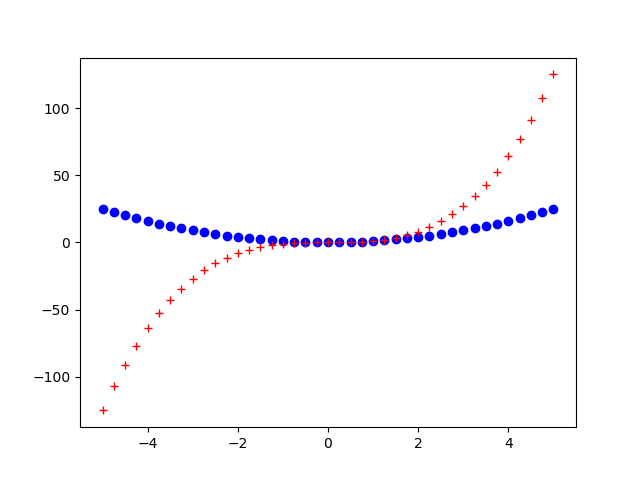

In [6]:
plt::plot(x_row, y_row, "bo");
plt::plot(x_row, z_row, "r+");
plt::save("../../test/test2.png");
auto img = im::image("../../test/test2.png");
img

## Forward Mode AD

For a function _f_ of several inputs and single (scalar) output, forward mode AD can be used to compute (or, in case of Clad, create a function) computing a directional derivative of _f_ with respect to a single specified input variable. Moreover, the generated derivative function has the same signature as the original function _f_, however its return value is the value of the derivative.

In [7]:
double fn(double x, double y) {
  return x*x*y + y*y;
}

In [8]:
auto fn_dx = clad::differentiate(fn, "x");

In [9]:
fn_dx.execute(5, 3)

30.000000

## Reverse Mode AD

Reverse-mode AD enables the gradient computation within a single pass of the computation graph of _f_ using at most a constant factor (around 4) more arithmetical operations compared to the original function. While its constant factor and memory overhead is higher than that of the forward-mode, it is independent of the number of inputs.

Moreover, the generated function has void return type and same input arguments. The function has an additional argument of type T*, where T is the return type of _f_. This is the “result” argument which has to point to the beginning of the vector where the gradient will be stored.

In [10]:
double fn(double x, double y) {
  return x*x + y*y;
}

In [11]:
auto d_fn_2 = clad::gradient(fn, "x, y");
double d_x, d_y;

In [12]:
d_fn_2.dump();

The code is: void fn_grad(double x, double y, clad::array_ref<double> _d_x, clad::array_ref<double> _d_y) {
    double _t2;
    double _t3;
    double _t4;
    double _t5;
    _t3 = x;
    _t2 = x;
    _t5 = y;
    _t4 = y;
    double fn_return = _t3 * _t2 + _t5 * _t4;
    goto _label0;
  _label0:
    {
        double _r0 = 1 * _t2;
        * _d_x += _r0;
        double _r1 = _t3 * 1;
        * _d_x += _r1;
        double _r2 = 1 * _t4;
        * _d_y += _r2;
        double _r3 = _t5 * 1;
        * _d_y += _r3;
    }
}



## Hessian

In [13]:
double kinetic_energy(double mass, double velocity) {
  return mass * velocity * velocity * 0.5;
}

In [14]:
auto hessian = clad::hessian(kinetic_energy, "mass, velocity");
double matrix[4];
hessian.execute(10, 2, matrix)

In [15]:
matrix

{ 0.0000000, 2.0000000, 2.0000000, 10.000000 }

## Jacobian

In [16]:
void fn_jacobian(double i, double j, double *res) {
  res[0] = i*i;
  res[1] = j*j;
  res[2] = i*j;
}

In [17]:
auto d_fn = clad::jacobian(fn_jacobian);
double res[3] = {0, 0, 0};
double derivatives[6] = {0, 0, 0, 0, 0, 0};
d_fn.execute(3, 5, res, derivatives);

In [18]:
derivatives

{ 6.0000000, 0.0000000, 0.0000000, 10.000000, 5.0000000, 3.0000000 }

In [19]:
std::cout<<"Jacobian matrix:\n";
  for (int i=0; i<3; ++i) {
    for (int j=0; j<2; ++j) {
      std::cout<<derivatives[i*2 + j]<<" ";
    }
    std::cout<<"\n";
  }

Jacobian matrix:
6 0 
0 10 
5 3 


## Functors

In [20]:
class Equation {
  double m_x, m_y;

  public:
  Equation(double x, double y) : m_x(x), m_y(y) {}
  double operator()(double i, double j) {
    return m_x*i*j + m_y*i*j;
  }
  void setX(double x) {
    m_x = x;
  }
};

In [21]:
Equation E(3,5);
auto d_E = clad::differentiate(E, "i");

In [22]:
d_E.dump()

The code is: double operator_call_darg0(double i, double j) {
    double _d_i = 1;
    double _d_j = 0;
    double &_t2 = this->m_x;
    double _t3 = _t2 * i;
    double &_t4 = this->m_y;
    double _t5 = _t4 * i;
    return (0. * i + _t2 * _d_i) * j + _t3 * _d_j + (0. * i + _t4 * _d_i) * j + _t5 * _d_j;
}

